In [ ]:
!unzip "/content/drive/MyDrive/cat and dog/images.zip" -d "/content/drive/MyDrive/computer_vision/segmentation/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/computer_vision/segmentation/images/Egyptian_Mau_90.jpg  
  inflating: /content/drive/MyDrive/computer_vision/segmentation/images/Egyptian_Mau_91.jpg  
  inflating: /content/drive/MyDrive/computer_vision/segmentation/images/Egyptian_Mau_92.jpg  
  inflating: /content/drive/MyDrive/computer_vision/segmentation/images/Egyptian_Mau_93.jpg  
  inflating: /content/drive/MyDrive/computer_vision/segmentation/images/Egyptian_Mau_94.jpg  
  inflating: /content/drive/MyDrive/computer_vision/segmentation/images/Egyptian_Mau_95.jpg  
  inflating: /content/drive/MyDrive/computer_vision/segmentation/images/Egyptian_Mau_96.jpg  
  inflating: /content/drive/MyDrive/computer_vision/segmentation/images/Egyptian_Mau_97.jpg  
  inflating: /content/drive/MyDrive/computer_vision/segmentation/images/Egyptian_Mau_98.jpg  
  inflating: /content/drive/MyDrive/computer_vision/segmentation/images/Egyptian_Mau_99.jpg  
  inflati

##9.2 An image segmentation example


In [1]:
import os
input_dir = "/content/drive/MyDrive/computer_vision/segmentation/images"
target_dir = "/content/drive/MyDrive/computer_vision/annotations/trimaps"
input_img_paths = sorted(
 [os.path.join(input_dir, fname)
 for fname in os.listdir(input_dir)
 if fname.endswith(".jpg")])
target_paths = sorted(
 [os.path.join(target_dir, fname)
 for fname in os.listdir(target_dir)
 if fname.endswith(".png") and not fname.startswith(".")])

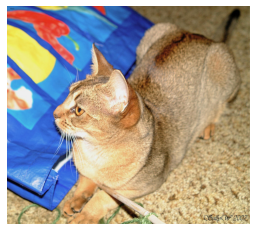

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

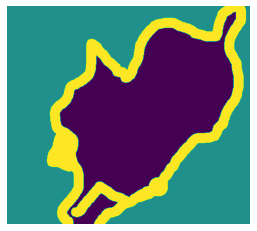

In [3]:
def display_target(target_array):
 normalized_array = (target_array.astype("uint8") - 1) * 127
 plt.axis("off")
 plt.imshow(normalized_array[:, :, 0])
 
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [4]:
import numpy as np
import random
img_size = (200, 200)
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
 return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
 img = img_to_array(
 load_img(path, target_size=img_size, color_mode="grayscale"))
 img = img.astype("uint8") - 1
 return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [5]:
print(len(train_input_imgs))
print(len(train_targets))
print(len(val_input_imgs))
print(len(val_targets))


6390
6390
1000
1000


In [6]:
from tensorflow import keras
from tensorflow.keras import layers
def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
  x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose( 64, 3, activation="relu", padding="same", strides=2)(x)
  outputs = layers.Conv2D(num_classes, 3, activation="softmax",padding="same")(x)
  model = keras.Model(inputs, outputs)
  return model

model = get_model(img_size=img_size, num_classes=3)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [8]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

In [9]:
callbacks = [
 keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
 save_best_only=True)
]

In [10]:
history = model.fit(train_input_imgs, train_targets,
 epochs=50,
 callbacks=callbacks,
 batch_size=64,
 validation_data=(val_input_imgs, val_targets))


Epoch 1/50
100/100 [==============================] - 157s 1s/step - loss: 1.1142 - val_loss: 0.9135
Epoch 2/50
100/100 [==============================] - 124s 1s/step - loss: 0.9286 - val_loss: 0.8099
Epoch 3/50
100/100 [==============================] - 124s 1s/step - loss: 0.8648 - val_loss: 0.7572
Epoch 4/50
100/100 [==============================] - 125s 1s/step - loss: 0.8011 - val_loss: 0.6850
Epoch 5/50
100/100 [==============================] - 125s 1s/step - loss: 0.7286 - val_loss: 0.8113
Epoch 6/50
100/100 [==============================] - 125s 1s/step - loss: 0.6610 - val_loss: 0.5898
Epoch 7/50
100/100 [==============================] - 125s 1s/step - loss: 0.6258 - val_loss: 0.5788
Epoch 8/50
100/100 [==============================] - 125s 1s/step - loss: 0.5912 - val_loss: 0.5419
Epoch 9/50
100/100 [==============================] - 124s 1s/step - loss: 0.5626 - val_loss: 0.4996
Epoch 10/50
100/100 [==============================] - 124s 1s/step - loss: 0.5560 - val_lo

In [11]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]

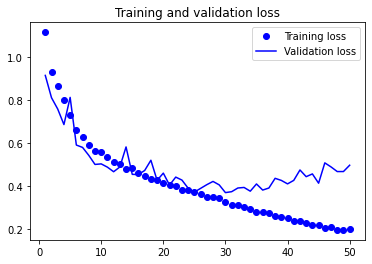

In [12]:
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

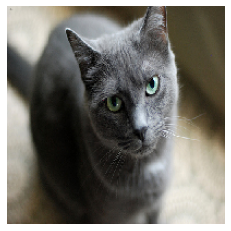

In [18]:
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")
i = 6
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]



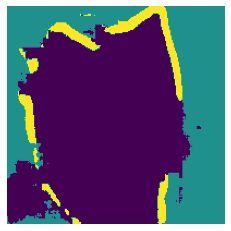

In [19]:
def display_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask *= 127
  plt.axis("off")
  plt.imshow(mask)
display_mask(mask)

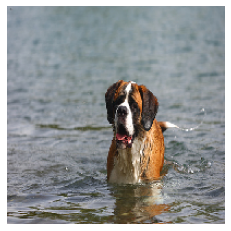

In [23]:
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")
i = 0
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]

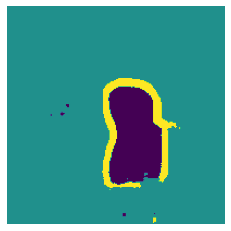

In [24]:

def display_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask *= 127
  plt.axis("off")
  plt.imshow(mask)
display_mask(mask)

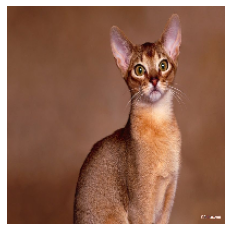

In [25]:
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")
i = 1
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]

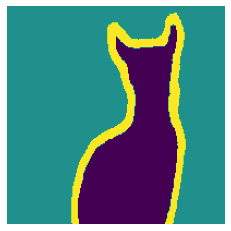

In [26]:

def display_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask *= 127
  plt.axis("off")
  plt.imshow(mask)
display_mask(mask)

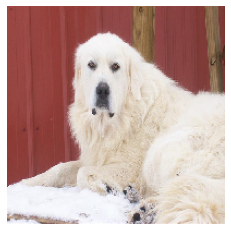

In [28]:
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")
i = 3
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]

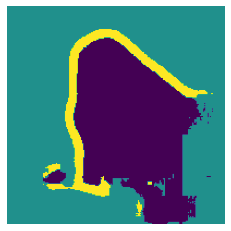

In [29]:

def display_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask *= 127
  plt.axis("off")
  plt.imshow(mask)
display_mask(mask)